# Лабораторная работа №5

|Студент| Лошманов Ю. А. |
|:-----:|:-:|
|Группа|М8О-406Б-19|

Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,t)$. Исследовать зависимость погрешности от сеточных параметров $\tau, h$.

**Вариант 6**
$$$$
$\displaystyle\frac{\partial u}{\partial t} = \displaystyle\frac{\partial^2 u}{\partial x^2} + \cos x(\cos t + \sin t)$
$$$$
$u(0, \: t) = \sin{t}$
$$$$
$u_{x} (\frac{\pi}{2}, \: t) = - \sin t$
$$$$
$u(x, \: 0) = 0$
$$$$
$U(x, \: t) = \sin t \cos x$
$$$$

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
eq = {
    'l': np.pi / 2,
    'psi': lambda x: 0,
    'f': lambda x, t: np.cos(x) * (np.cos(t) + np.sin(t)),
    'phi0': lambda t: np.sin(t),
    'phi1': lambda t: -np.sin(t),
    'solution': lambda x, t: np.sin(t) * np.cos(x),
}

In [24]:
def tma(a, b, c, d):
    size = len(a)
    p, q = [], []
    p.append(-c[0] / b[0])
    q.append(d[0] / b[0])
    for i in range(1, size):
        p_tmp = -c[i] / (b[i] + a[i] * p[i - 1])
        q_tmp = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])
        p.append(p_tmp)
        q.append(q_tmp)
    x = [0 for _ in range(size)]
    x[size - 1] = q[size - 1]
    for i in range(size - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]
    return x


def get_zeros(N, K):
    lst = [np.zeros(N) for _ in range(0, 4)]
    lst.append(np.zeros((K, N)))
    return lst

In [25]:
class Eq:
    def __init__(self, args):
        self.l = args['l']
        self.f = args['f']
        self.psi = args['psi']
        self.phi0 = args['phi0']
        self.phi1 = args['phi1']
        self.bound_type = args['bound_type']
        self.solve = args['solution']


class Parabolic:
    def __init__(self, args, N, K, T):
        self.alpha = 0
        self.beta = 1
        self.gamma = 1
        self.delta = 0
        self.data = Eq(args)
        self.a = 1
        self.b = 0
        self.c = 0
        self.h = self.data.l / N
        self.tau = T / K
        self.sigma = self.a ** 2 * self.tau / (self.h ** 2)

    def solve_analytic(self, N, K, T):
        self.h = self.data.l / N
        self.tau = T / K
        u = np.zeros((K, N))
        for i in range(K):
            for j in range(N):
                u[i][j] = self.data.solve(j * self.h, i * self.tau)
        return u

    def calc(self, a, b, c, d, u, k, N, T, K):
        t = np.arange(0, T, T / K)
        for j in range(1, N):
            a[j] = self.sigma
            b[j] = -(1 + 2 * self.sigma)
            c[j] = self.sigma
            d[j] = -u[k][j]

        if self.data.bound_type == 'a1p1':
            a[0] = 0
            b[0] = self.beta - (self.alpha / self.h)
            c[0] = self.alpha / self.h
            d[0] = self.data.phi0(t[k]) / (self.beta - self.alpha / self.h)
            a[-1] = -self.gamma / self.h
            b[-1] = self.gamma / self.h + self.delta
            c[-1] = 0
            d[-1] = self.data.phi1(t[k]) / (self.gamma / self.h + self.delta)
        elif self.data.bound_type == 'a1p2':
            a[0] = 0
            b[0] = -(1 + 2 * self.sigma)
            c[0] = self.sigma
            d[0] = -(u[k - 1][0] + self.sigma * self.data.phi0(k * self.tau)) - \
                   self.tau * self.data.f(0, k * self.tau)
            a[-1] = self.sigma
            b[-1] = -(1 + 2 * self.sigma)
            c[-1] = 0
            d[-1] = -(u[k - 1][-1] + self.sigma * self.data.phi1(k * self.tau)) - \
                    self.tau * self.data.f((N - 1) * self.h, k * self.tau)
        elif self.data.bound_type == 'a1p3':
            a[0] = 0
            b[0] = -(1 + 2 * self.sigma)
            c[0] = self.sigma
            d[0] = -((1 - self.sigma) * u[k - 1][1] + self.sigma / 2 * u[k - 1][0]) - self.tau \
                   * self.data.f(0, k * self.tau) - self.sigma * self.data.phi0(
                k * self.tau)
            a[-1] = self.sigma
            b[-1] = -(1 + 2 * self.sigma)
            c[-1] = 0
            d[-1] = self.data.phi1(k * self.tau) + self.data.f((N - 1) * self.h, k * self.tau) \
                    * self.h / (2 * self.tau) * u[k - 1][-1]

    def solve_implicit(self, N, K, T):
        lst = get_zeros(N, K)
        a = lst[0]
        b = lst[1]
        c = lst[2]
        d = lst[3]
        u = lst[4]

        for i in range(1, N - 1):
            u[0][i] = self.data.psi(i * self.h)
        u[0][-1] = 0

        for k in range(1, K):
            self.calc(a, b, c, d, u, k, N, T, K)
            u[k] = tma(a, b, c, d)

        return u

    def solve_explicit(self, N, K, T):
        u = np.zeros((K, N))
        t = np.arange(0, T, T / K)
        x = np.arange(0, np.pi / 2, np.pi / 2 / N)
        for j in range(1, N - 1):
            u[0][j] = self.data.psi(j * self.h)

        for k in range(1, K):
            for j in range(1, N - 1):
                  u[k][j] = (u[k - 1][j + 1] * (self.a ** 2.0 * self.tau / self.h ** 2.0)
                           - 2 * u[k - 1][j] * (self.a ** 2.0 * self.tau / self.h ** 2.0)
                           + u[k - 1][j - 1] * (self.a ** 2.0 * self.tau / self.h ** 2.0)
                           + u[k - 1][j]
                           + self.tau * self.data.f(x[j], t[k]))

            if self.data.bound_type == 'a1p1':
                u[k][0] = self.data.phi0(t[k])
                u[k][-1] = (self.data.phi1(t[k]) + self.gamma / self.h * u[k][-2]) / (self.delta + self.gamma / self.h)
            elif self.data.bound_type == 'a1p2':
                u[k][0] = self.data.phi0(t[k])
                u[k][-1] = (((2.0 * self.gamma * self.a / self.h / (2.0 * self.a + self.h * self.b)) * u[k][-2] +
                             (self.gamma * self.h / self.tau / (2.0 * self.a + self.h * self.b)) * u[k - 1][-1] +
                             (self.gamma * self.h * self.c / (2.0 * self.a + self.h * self.b)) * self.data.f(
                            self.data.l, t[k]) + self.data.phi1(t[k])) / (
                                    (2.0 * self.gamma * self.a / self.h / (2.0 * self.a + self.h * self.b)) + (
                                    self.gamma * self.h / self.tau / (2.0 * self.a + self.h * self.b)) - (
                                            self.gamma * self.h * self.c / (
                                            2.0 * self.a + self.h * self.b)) * self.c + self.delta))
            elif self.data.bound_type == 'a1p3':
                u[k][0] = self.data.phi0(t[k])
                u[k][-1] = (self.data.phi1(k * self.tau) + u[k][-2] / self.h + 2 * self.tau * u[k - 1][-1] / self.h) / \
                           (1 / self.h + 2 * self.tau / self.h)
        return u

    def solve_crank_nicolson(self, N, K, T):
        theta = 0.5
        lst = get_zeros(N, K)
        a = lst[0]
        b = lst[1]
        c = lst[2]
        d = lst[3]
        u = lst[4]
        for i in range(1, N - 1):
            u[0][i] = self.data.psi(i * self.h)

        for k in range(1, K):
            self.calc(a, b, c, d, u, k, N, T, K)

            tmp_imp = tma(a, b, c, d)

            tmp_exp = np.zeros(N)
            tmp_exp[0] = self.data.phi0(self.tau)
            for j in range(1, N - 1):
                tmp_exp[j] = self.sigma * u[k - 1][j + 1] + (1 - 2 * self.sigma) * u[k - 1][j] + \
                             self.sigma * u[k - 1][j - 1] + self.tau * self.data.f(j * self.h, k * self.tau)
            tmp_exp[-1] = self.data.phi1(self.tau)

            for j in range(N):
                u[k][j] = theta * tmp_imp[j] + (1 - theta) * tmp_exp[j]

        return u

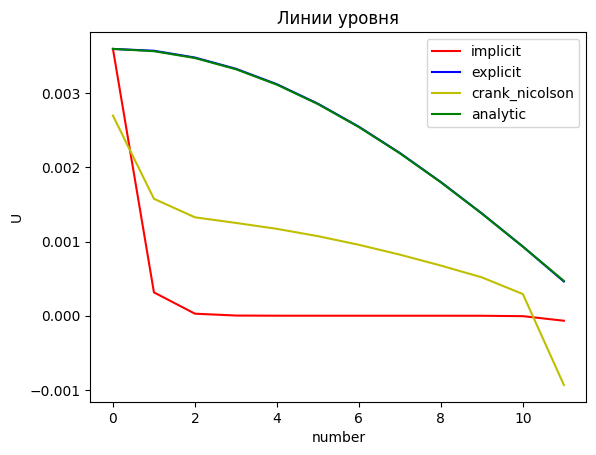

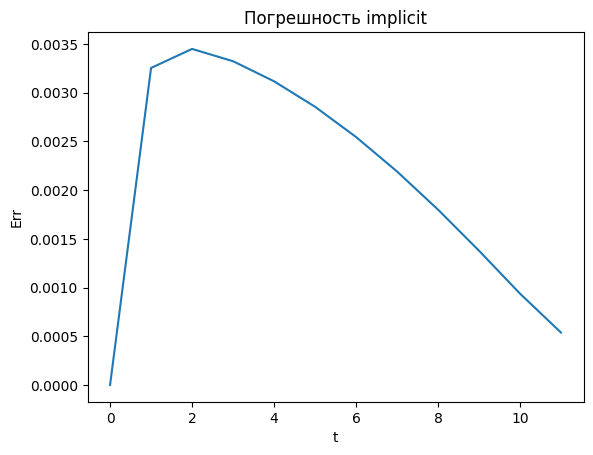

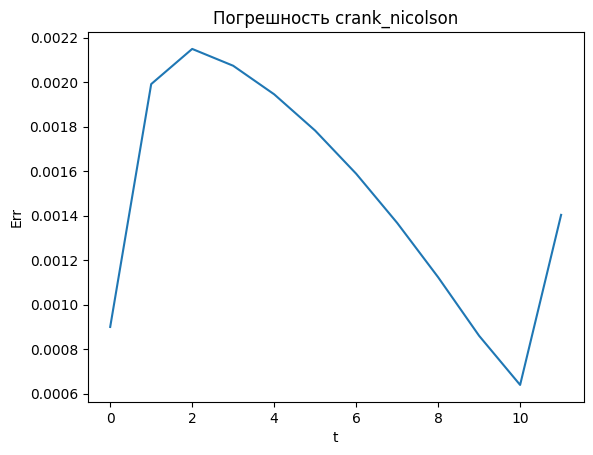

In [26]:
def compare_error(dict_):
    error = [[abs(i - j) for i, j in zip(x, y)] for x, y in zip(dict_['numerical'], dict_['analytic'])]
    return error


def show(dict_, time=0):
    fig = plt.figure()
    plt.title('Линии уровня')
    plt.plot(dict_['implicit'][time], color='r', label='implicit')
    plt.plot(dict_['explicit'][time], color='b', label='explicit')
    plt.plot(dict_['crank_nicolson'][time], color='y', label='crank_nicolson')
    plt.plot(dict_['analytic'][time], color='g', label='analytic')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('number')
    plt.show()

    plt.title('Погрешность explicit')
    plt.plot(abs(dict_['explicit'][time] - dict_['analytic'][time]))
    plt.ylabel('Err')
    plt.xlabel('t')
    plt.show()

    plt.title('Погрешность implicit')
    plt.plot(abs(dict_['implicit'][time] - dict_['analytic'][time]))
    plt.ylabel('Err')
    plt.xlabel('t')
    plt.show()

    plt.title('Погрешность crank_nicolson')
    plt.plot(abs(dict_['crank_nicolson'][time] - dict_['analytic'][time]))
    plt.ylabel('Err')
    plt.xlabel('t')
    plt.show()


N, K, T = 12, 10000, 18

args = eq
args['bound_type'] = 'a1p1'

solver = Parabolic(args, N, K, T)
dict_ans = {
    'implicit': solver.solve_implicit(N, K, T),
    'explicit': solver.solve_explicit(N, K, T),
    'crank_nicolson': solver.solve_crank_nicolson(N, K, T),
    'analytic': solver.solve_analytic(N, K, T)
}
show(dict_ans, 2)

## Апроксимация 3-х точечная второго порядка

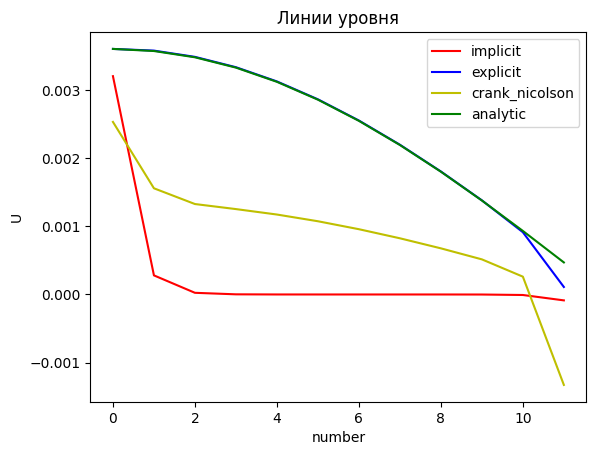

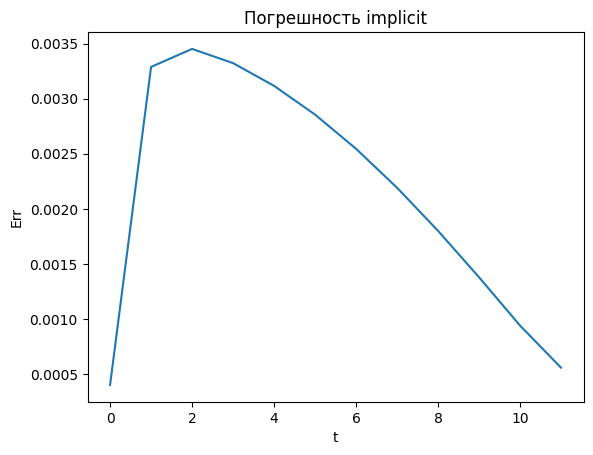

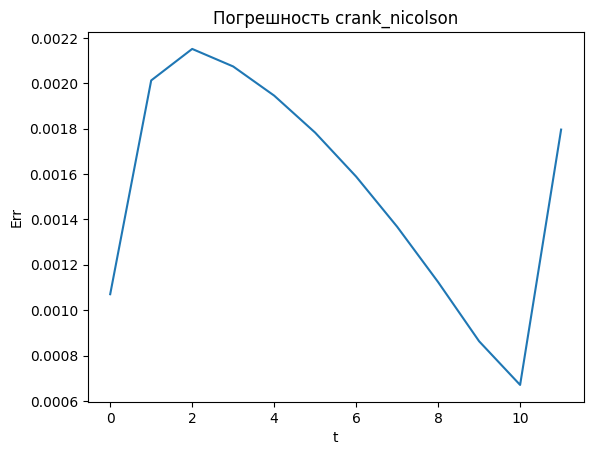

In [27]:
N, K, T = 12, 10000, 18

args = eq
args['bound_type'] = 'a1p2'
solver = Parabolic(args, N, K, T)
dict_ans = {
    'implicit': solver.solve_implicit(N, K, T),
    'explicit': solver.solve_explicit(N, K, T),
    'crank_nicolson': solver.solve_crank_nicolson(N, K, T),
    'analytic': solver.solve_analytic(N, K, T)
}
show(dict_ans, 2)

## Апроксимация 2-х точечная 2 порядка

/var/folders/83/2lkmbrc10y3bnb04s4tnnht80000gn/T/ipykernel_23060/301663272.py:73: RuntimeWarning: overflow encountered in double_scalars
  d[-1] = self.data.phi1(k * self.tau) + self.data.f((N - 1) * self.h, k * self.tau) \
/var/folders/83/2lkmbrc10y3bnb04s4tnnht80000gn/T/ipykernel_23060/4192919542.py:8: RuntimeWarning: invalid value encountered in double_scalars
  q_tmp = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])


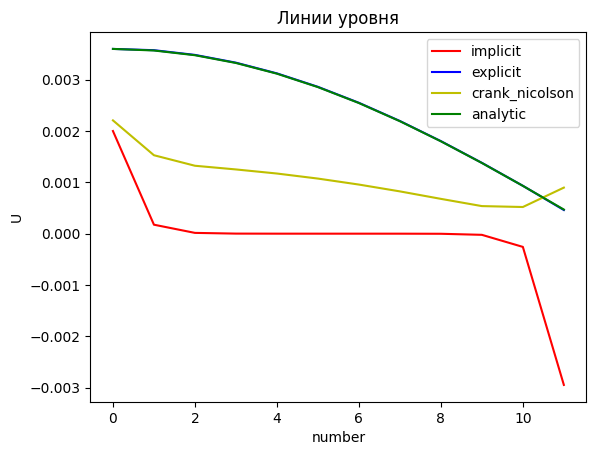

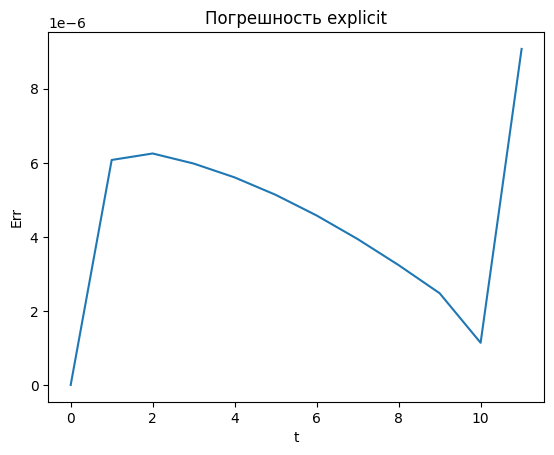

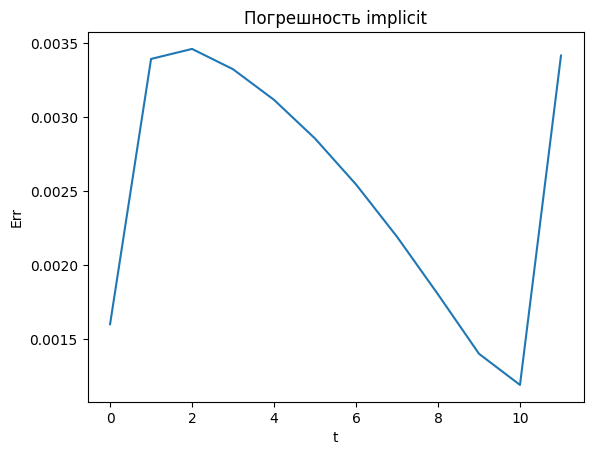

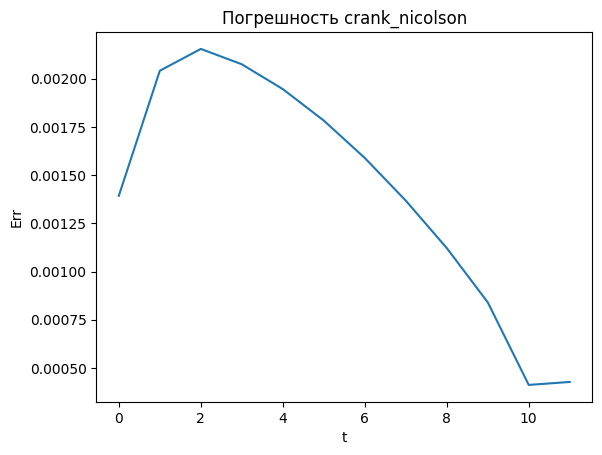

In [28]:
N, K, T = 12, 10000, 18

args = eq
args['bound_type'] = 'a1p3'
solver = Parabolic(args, N, K, T)
dict_ans = {
    'implicit': solver.solve_implicit(N, K, T),
    'explicit': solver.solve_explicit(N, K, T),
    'crank_nicolson': solver.solve_crank_nicolson(N, K, T),
    'analytic': solver.solve_analytic(N, K, T)
}
show(dict_ans, 2)

## Исследование зависимости погрешности от величина tau и h

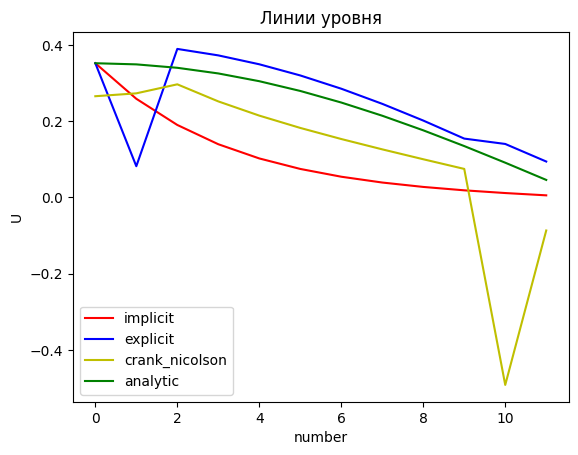

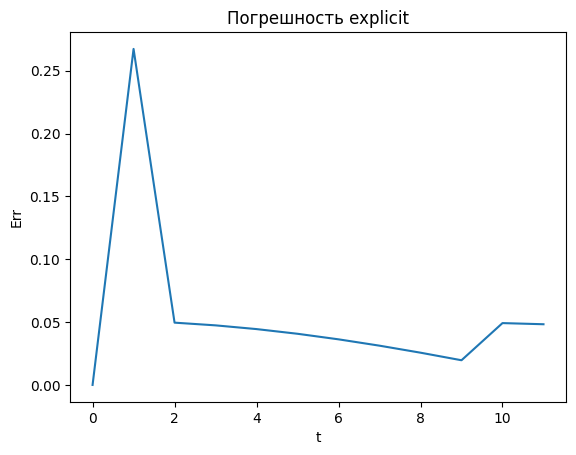

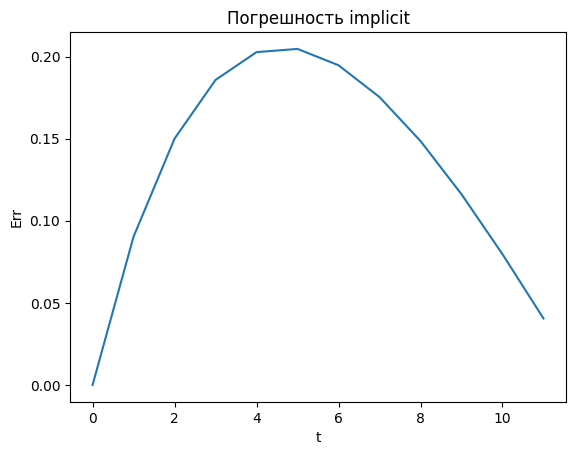

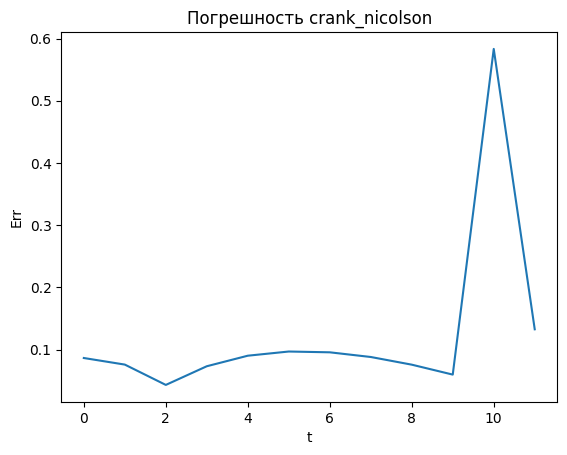

In [29]:
N, K, T = 12, 100, 18

args = eq
args['bound_type'] = 'a1p1'
solver = Parabolic(args, N, K, T)
dict_ans = {
    'implicit': solver.solve_implicit(N, K, T),
    'explicit': solver.solve_explicit(N, K, T),
    'crank_nicolson': solver.solve_crank_nicolson(N, K, T),
    'analytic': solver.solve_analytic(N, K, T)
}
show(dict_ans, 2)

/var/folders/83/2lkmbrc10y3bnb04s4tnnht80000gn/T/ipykernel_23060/301663272.py:103: RuntimeWarning: overflow encountered in double_scalars
  u[k][j] = (u[k - 1][j + 1] * (self.a ** 2.0 * self.tau / self.h ** 2.0)
/var/folders/83/2lkmbrc10y3bnb04s4tnnht80000gn/T/ipykernel_23060/301663272.py:104: RuntimeWarning: overflow encountered in double_scalars
  - 2 * u[k - 1][j] * (self.a ** 2.0 * self.tau / self.h ** 2.0)
/var/folders/83/2lkmbrc10y3bnb04s4tnnht80000gn/T/ipykernel_23060/301663272.py:105: RuntimeWarning: overflow encountered in double_scalars
  + u[k - 1][j - 1] * (self.a ** 2.0 * self.tau / self.h ** 2.0)
/var/folders/83/2lkmbrc10y3bnb04s4tnnht80000gn/T/ipykernel_23060/301663272.py:114: RuntimeWarning: overflow encountered in double_scalars
  u[k][-1] = (((2.0 * self.gamma * self.a / self.h / (2.0 * self.a + self.h * self.b)) * u[k][-2] +
/var/folders/83/2lkmbrc10y3bnb04s4tnnht80000gn/T/ipykernel_23060/301663272.py:103: RuntimeWarning: invalid value encountered in double_scalars
 

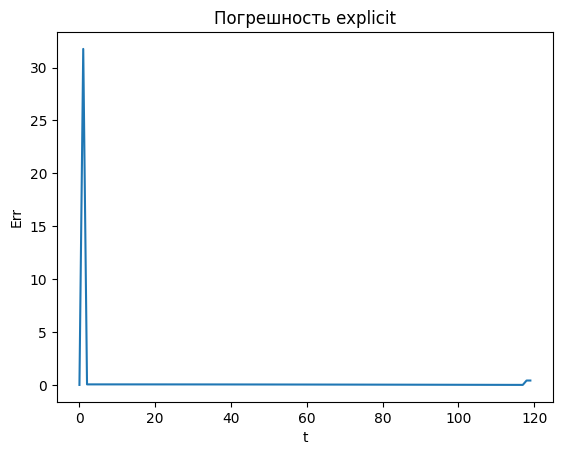

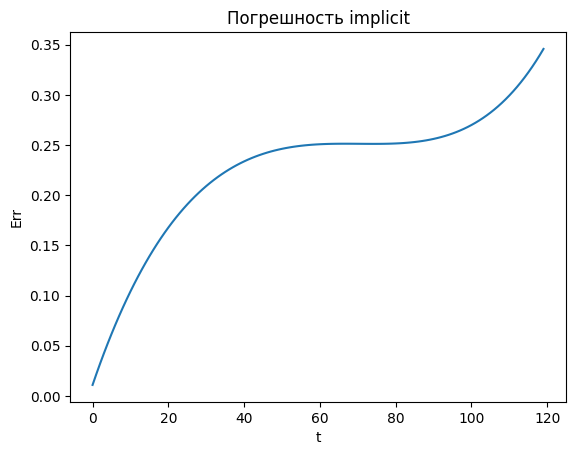

In [30]:
N, K, T = 120, 100, 18

args = eq
args['bound_type'] = 'a1p2'
solver = Parabolic(args, N, K, T)
dict_ans = {
    'implicit': solver.solve_implicit(N, K, T),
    'explicit': solver.solve_explicit(N, K, T),
    'crank_nicolson': solver.solve_crank_nicolson(N, K, T),
    'analytic': solver.solve_analytic(N, K, T)
}
show(dict_ans, 2)

## Выводы:
Как видно из графиков погрешности, в основном очередь на неё влияет величина параметра $\tau$, а вот количество шагов $h$ оказывает отрицательное влияние, увеличивая погрешность в разы.